<a href="https://colab.research.google.com/github/Bantami/All-Optical-QPM/blob/main/Colab/cnn_inference_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Colab Setting up Scripts


*   Downloading repository, dataset and models
*   Install pip packages


In [ ]:
!git clone https://github.com/Bantami/All-Optical-QPM.git

!chmod 755 All-Optical-QPM/colab_setup.sh
!All-Optical-QPM/colab_setup.sh

Cloning into 'All-Optical-QPM'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 166 (delta 84), reused 100 (delta 44), pack-reused 0
Receiving objects: 100% (166/166), 1.77 MiB | 12.65 MiB/s, done.
Resolving deltas: 100% (84/84), done.
     |████████████████████████████████| 232 kB 7.3 MB/s 
     |████████████████████████████████| 49.9 MB 48 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Downloading...
From: https://drive.google.com/uc?id=1ickDfs6bA-YM7RQSaMPRqFnC7YApjW8e
To: /content/hela.zip
100% 303M/303M [00:01<00:00, 242MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tHBWjNJPRHf1VX0XJicLIKs8av43_TPz
To: /content/models.zip
100% 3.27M

### Import Libraries

In [ ]:
import sys
sys.path.append('All-Optical-QPM')

from torch import nn
from collections import OrderedDict
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
from torchvision import datasets, transforms
import math
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import glob
import os
import json

from modules.dataloaders import *
from modules.diffraction import *
from modules.other_models import *
from modules.eval_metrics import *
from modules.vis_utils import *

## Use Pretrained Models: Model Selection and Loading

In [ ]:
pretrained_models = {
    'MNIST'       : 'MNIST_cnn',
    'HeLa [0,Pi]' : 'Hela_pi_cnn',
    'HeLa [0,2Pi]': 'Hela_2pi_cnn',

} 

# Selecting a pretrained model
data_type = 'HeLa [0,Pi]'
model = pretrained_models[data_type]

In [ ]:
path = 'models/'
folder = path+f'{model}'

model_name = '.pth'

saved = torch.load(folder + model_name,map_location='cuda:0')

cfg   = saved['cfg']
cfg['device'] = 'cuda:0'

In [ ]:
if 'last_bias' not in cfg.keys() or 'output_scale' not in cfg.keys(): 
    # Adding missing configurations required for the current model implementation function. Default configs are used
    cfg['last_bias'] = True
    cfg['all_bias'] = False
    cfg['output_scale'] = 1
    cfg['output_scale_learnable'] = False

model = eval(cfg['model'])(cfg).to(cfg['device'])
model.load_state_dict(saved['state_dict'])
model.eval()

complex_cnn(
  (conv1): ComplexConv2d(
    (conv_r): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv_i): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (conv2): ComplexConv2d(
    (conv_r): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv_i): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (conv3): ComplexConv2d(
    (conv_r): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv_i): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (conv4): ComplexConv2d(
    (conv_r): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv_i): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (conv5): ComplexConv2d(
    (conv_r): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_i): Conv2d(1, 1, kernel_size=(3, 

### Loading Configs

In [ ]:
torch.manual_seed(cfg['torch_seed'])

shrinkFactor = cfg['shrink_factor'] if 'shrink_factor' in cfg else 1
img_size     = cfg['img_size']
angle_max    = eval(cfg['angle_max'])
inp_circular = cfg['input_circular'] if 'input_circular' in cfg.keys() else False # If the input field is propagated through a circular aperture
device = cfg['device']

if(shrinkFactor!=1):
    # To obtain the starting position and ending position of the original image within the padded image
    csize = int(img_size/shrinkFactor)
    spos  = int((img_size - csize)/2)
    epos  = spos + csize
else:
    spos = 0
    epos = img_size
    
dataloader = eval(cfg['get_dataloaders'])
print(cfg['get_dataloaders'])

train_loader, val_loader =  dataloader(cfg['img_size'], cfg['train_batch_size'], cfg['torch_seed'],  task_type= cfg['task_type'], shrinkFactor = shrinkFactor, cfg = cfg)
print(len(val_loader))

get_qpm_np_dataloaders
68


### Run Inference on unseen data

In [ ]:
ssim_scores = []

for idx, (x, y) in enumerate(val_loader): # Test loop   
    gt = x[:,0].to(cfg['device']) # Groung truth image (input)
    pred_img,out_scale = model(gt) 

    
    pred_img = pred_img[:,spos:epos,spos:epos] # Crop the reconstructed image
    gt       = gt[:,spos:epos,spos:epos]       # Crop the groundtruth image
    
    pred_out = out_scale * pred_img.abs()**2

    if(cfg['get_dataloaders']=="get_mnist_dataloaders"):
        gt_angle = gt.angle()/angle_max
    else:
        # CLIP ANGLE TO -> [0, angle_max]
        y = torch.clip(y, min= 0, max= angle_max).to(device)
        gt_angle = y[:,0].to(cfg['device'])[:,spos:epos,spos:epos] / angle_max
        
    ssim_scores.append(ssim_pytorch(pred_out.float(), gt_angle.float(), k= 11,range_independent=False))
    

print("Mean SSIM = ", np.mean(ssim_scores))

Mean SSIM =  0.9051738451508915


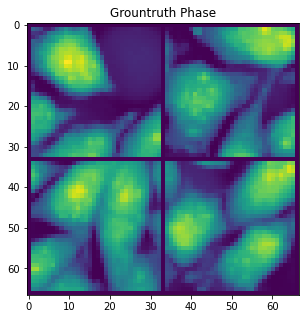

In [ ]:
# Plotting ground truth images
gt_img_set = gt.unsqueeze(dim= 1)[10:14]

k = gt_img_set.angle().detach().cpu()
k = cv2.cvtColor(make_grid(k, nrow=2, padding= 1).permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY)%(2*np.pi)


plt.figure(figsize=(5,5))
plt.title("Grountruth Phase")
plt.imshow(k)

Text(0.5, 1.0, 'Reconstructed : Intensity')

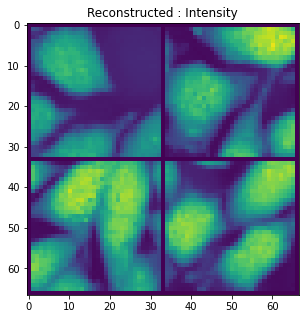

In [ ]:
# Plotting the corresponding reconstructed images
pred_img_set = pred_out.unsqueeze(dim= 1)[10:14]
 

plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(make_grid(pred_img_set.abs().detach().cpu(), nrow=2, padding= 1).permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY),vmin = 0, vmax =1)
plt.title('Reconstructed : Intensity')